In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from datetime import datetime
from functools import reduce
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_directory = '../data/'
file_names = [
    'Batch_corrected_Expression_Public_24Q4_subsetted.csv',
    'Damaging_Mutations_subsetted.csv', 
    'Harmonized_RPPA_CCLE_subsetted.csv',
    'Hotspot_Mutations_subsetted.csv', 
    'IC50_AUC_merged.csv', 
    'Metabolomics_subsetted.csv',
    'miRNA_Expression_subsetted.csv',
    'Omics_Absolute_CN_Gene_Public_24Q4_subsetted.csv'
    ]
model_type = "Elastic_Net_MLP"

# Data Load

In [3]:
smiles = pd.read_csv("../data/drugID_name_pubchem_smiles.csv")

In [4]:
# load ChemBERTa tokenizer and model
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenize
tokens = tokenizer(smiles["smiles"].tolist(), padding=True, truncation=True, return_tensors="pt")

# embedded tokenized SMILES
with torch.no_grad():
    outputs = model(**tokens)

# CLS token (for now, we will only use CLS token)
cls_embeddings = outputs.last_hidden_state[:, 0, :] # (batch_size, hidden_dim)

cls_embeddings_np = cls_embeddings.cpu().numpy()

smiles["CLS"] = list(cls_embeddings_np)

print(smiles.head())

2025-03-12 01:06:17.750698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


   drugID          drugName  pubchemID  \
0    1003  (+)-CAMPTOTHECIN      24360   
1    1004            VELBAN    5388983   
2    1006        CYTARABINE       6253   
3    1007         DOCETAXEL     148124   
4    1010         GEFITINIB     123631   

                                              smiles  \
0  CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...   
1  CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...   
2                 C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O   
3  CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...   
4  COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...   

                                                 CLS  
0  [-0.050625782, 0.8847862, -1.6744756, 1.318763...  
1  [1.5243864, 0.27689624, -0.80197245, -0.993637...  
2  [-0.3921864, 0.06059088, -0.8843427, 0.2352088...  
3  [0.51168895, 0.7362516, -1.3978798, -0.6953381...  
4  [-0.7337884, 0.7460441, -1.1952801, 1.1188803,...  


In [5]:
IC50_AUC = pd.read_csv("../data/IC50_AUC_merged.csv")
IC50_AUC = IC50_AUC.rename(columns={"Unnamed: 0": "CellLineID"})

In [6]:
melted = IC50_AUC.melt(
    id_vars=["CellLineID"],  # fixed column
    var_name="metric_drug",  # column names that will be one single column
    value_name="value"       
)
melted.head()

,CellLineID,metric_drug,value
0,ACH-000001,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,NaN
1,ACH-000002,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-6.358658
2,ACH-000004,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-6.277264
3,ACH-000006,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-5.994797
4,ACH-000007,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,NaN


In [7]:
# ex: "Drug sensitivity AUC (Sanger GDSC2) CAMPTOTHECIN (GDSC2:1003)" -> (AUC), (CAMPTOTHECIN), (1003)
pattern = r"(AUC|IC50).*?\((Sanger GDSC2)\)\s+(.*?)\s+\(GDSC2:(\d+)\)"

# (AUC|IC50) -> 1) AUC or IC50
# (.*?)      -> 3) Drug name (minimum match)
# (\d+)      -> 4) drug number from GDSC2:XXXX

In [8]:
melted[["Metric", "_sanger", "DrugName", "DrugNumber"]] = melted["metric_drug"].str.extract(pattern)
new_melted = melted[['CellLineID', 'value', 'Metric','DrugNumber']]
new_melted.head()

,CellLineID,value,Metric,DrugNumber
0,ACH-000001,NaN,IC50,1003
1,ACH-000002,-6.358658,IC50,1003
2,ACH-000004,-6.277264,IC50,1003
3,ACH-000006,-5.994797,IC50,1003
4,ACH-000007,NaN,IC50,1003


In [9]:
final_IC50_AUC = (
    new_melted
    .pivot(index=["CellLineID", "DrugNumber"], 
           columns="Metric", 
           values="value")
    #.reset_index()
)

In [10]:
final_IC50_AUC = final_IC50_AUC.dropna(subset=['AUC', 'IC50'], how='all') # drop the row that AUC and IC50 are both NAN
final_IC50_AUC.columns.name = None
final_IC50_AUC

AUC     IC50
CellLineID DrugNumber                   
ACH-000001 1003        0.967187      NaN
           1004        0.666062      NaN
           1005        0.977907      NaN
           1007        0.922989      NaN
           1010        0.957586      NaN
...                         ...      ...
ACH-002317 2096        0.946713      NaN
           2107        0.926422      NaN
           2109        0.916274  3.25832
           2110        0.906540      NaN
           2170        0.996681      NaN

[98430 rows x 2 columns]

In [11]:
final_IC50_AUC.to_csv("temp.csv") # had to save and reload to make CellLIneID and DrugNumber to column

In [12]:
IC50_AUC_final = pd.read_csv("temp.csv")

In [13]:
# merge IC50, AUC, and SMILES (CLS)
df_merged = pd.merge(IC50_AUC_final, smiles, left_on='DrugNumber', right_on='drugID', how='inner')

In [14]:
ic50_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'IC50']].copy()
ic50_data['AUC'] = None # each row will have either AUC or IC50 value. 
ic50_data = ic50_data.rename(columns={'IC50': 'IC50'})

auc_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'AUC']].copy()
auc_data['IC50'] = None 
auc_data = auc_data.rename(columns={'AUC': 'AUC'})

final_df = pd.concat([ic50_data, auc_data])
final_df = final_df.sort_values(by=['CellLineID', 'DrugNumber']).reset_index(drop=True)
final_df = final_df.dropna(subset=['AUC', 'IC50'], how='all').reset_index(drop=True)

final_df

/var/folders/rt/c2m6bx6n12j282w1_l6qv5l00000gn/T/ipykernel_73435/1315804172.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([ic50_data, auc_data])


,CellLineID,DrugNumber,smiles,CLS,IC50,AUC
0,ACH-000001,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050625782, 0.8847862, -1.6744756, 1.318763...",NaN,0.967187
1,ACH-000001,1004,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,"[1.5243864, 0.27689624, -0.80197245, -0.993637...",NaN,0.666062
2,ACH-000001,1005,N.N.[Cl-].[Cl-].[Pt+2],"[0.73499787, 0.018371219, -0.49584207, 0.29506...",NaN,0.977907
3,ACH-000001,1007,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,"[0.51168895, 0.7362516, -1.3978798, -0.6953381...",NaN,0.922989
4,ACH-000001,1010,COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...,"[-0.7337884, 0.7460441, -1.1952801, 1.1188803,...",NaN,0.957586
...,...,...,...,...,...,...
117641,ACH-002317,2107,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...,"[0.3243879, -0.20456098, -0.47426465, 0.152975...",NaN,0.926422
117642,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195233, -0.2668271, -1.0635843, -0.434819...",3.25832,NaN
117643,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195233, -0.2668271, -1.0635843, -0.434819...",NaN,0.916274
117644,ACH-002317,2110,C1CC(C1)NC2=NC=CC(=C2)C(=O)NCC(CN3CCC4=CC=CC=C...,"[-0.07692316, -0.47833252, -0.6763182, -0.5061...",NaN,0.906540


In [15]:
all_omics = []
files = file_names[:4] + file_names[5:]
for file in files: 
    omics = pd.read_csv(f'{data_directory}{file}')
    omics = omics.rename(columns={omics.columns[0]: "CellLineID"})
    all_omics.append(omics)
all_omics

[      CellLineID     NEMP2   SPDYE11      MED6    SPATA1    HMG20B    PITRM1  \
 0     ACH-000873  2.281262  0.016496  4.913394  0.592549  4.933815  5.068384   
 1     ACH-000860  2.397921 -0.007359  6.064227  0.790612  5.526024  5.495815   
 2     ACH-000439  1.961548  0.139871  4.366399  0.574739  5.879936  5.027458   
 3     ACH-000318  2.962951 -0.007359  6.028266  0.636129  4.722188  5.235858   
 4     ACH-001142  1.997125 -0.007359  4.781246  1.004993  5.559541  6.614231   
 ...          ...       ...       ...       ...       ...       ...       ...   
 1668  ACH-001843  2.425672  0.016474  5.064429  1.155729  6.132326  6.435993   
 1669  ACH-002074  2.435179  0.016474  4.795754  0.494388  5.265443  5.683454   
 1670  ACH-001164  1.893673  0.016474  4.460321  0.362453  5.729537  7.230451   
 1671  ACH-003180  2.717188  0.016474  4.991506  0.604765  5.400438  5.396326   
 1672  ACH-001979  2.882293  0.040215  4.678718  0.717236  6.455945  4.943213   
 
         TCIRG1    CDKN2B 

In [16]:
X_dimension_reduced_array = []
# PCA for batch expression and CN, variance for damaged

for i in range(len(all_omics)):
    omics = all_omics[i]
    if i == 0 or i == 6:
        X_cnv = omics.iloc[:, 1:]
        pca = PCA(n_components=500)
        X_pca = pca.fit_transform(X_cnv)

        X_pca_df = pd.DataFrame(X_pca)
        X_pca_df.insert(0, "CellLineID", omics["CellLineID"].values)

        print(X_pca_df.shape)
        X_dimension_reduced_array.append(X_pca_df)

    elif i == 1:
        omics_ = omics.drop(columns="CellLineID")
        # VarianceThreshold 설정 (0에 가까운 값이 대부분인 feature 제거)
        selector = VarianceThreshold(threshold=0.01) # 분산 0.01 이하의 feature 제거
        omics_reduced = selector.fit_transform(omics_)

        # 제거되지 않은 feature의 인덱스 가져오기
        selected_columns = omics_.columns[selector.get_support()]

        # DataFrame으로 변환 (컬럼 유지)
        X_reduced_df = pd.DataFrame(omics_reduced, columns=selected_columns)
        X_reduced_df = pd.concat([omics["CellLineID"], X_reduced_df], axis=1)

        print(X_reduced_df.shape)
        X_dimension_reduced_array.append(X_reduced_df)

    else:
        print(omics.shape)
        X_dimension_reduced_array.append(omics)





(1673, 501)
(1929, 1255)
(899, 145)
(1929, 540)
(927, 226)
(954, 735)
(1607, 501)


In [17]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='CellLineID', how='inner', suffixes=('', '_dup')), X_dimension_reduced_array + [final_df])
df_merged

,CellLineID,0,1,2,3,4,5,6,7,8,...,495_dup,496_dup,497_dup,498_dup,499_dup,DrugNumber,smiles,CLS,IC50,AUC
0,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,5.085078,1.337375,-0.553852,0.214822,1.292960,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050625782, 0.8847862, -1.6744756, 1.318763...",-4.325557,NaN
1,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,5.085078,1.337375,-0.553852,0.214822,1.292960,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050625782, 0.8847862, -1.6744756, 1.318763...",NaN,0.866413
2,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,5.085078,1.337375,-0.553852,0.214822,1.292960,1004,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,"[1.5243864, 0.27689624, -0.80197245, -0.993637...",NaN,0.906722
3,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,5.085078,1.337375,-0.553852,0.214822,1.292960,1005,N.N.[Cl-].[Cl-].[Pt+2],"[0.73499787, 0.018371219, -0.49584207, 0.29506...",NaN,0.955195
4,ACH-000873,8.385960,30.391703,0.819295,-44.671643,-26.321860,5.701811,31.807342,9.832625,0.288482,...,5.085078,1.337375,-0.553852,0.214822,1.292960,1006,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O,"[-0.3921864, 0.06059088, -0.8843427, 0.2352088...",NaN,0.932728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59298,ACH-001151,35.889203,44.332540,-8.323255,28.598083,13.124804,-8.325410,-16.091490,0.946869,20.182441,...,2.332157,1.486738,5.104578,-3.690235,4.956756,2096,CC1=CN=C(N=C1C2=CNC(=C2)C(=O)NC(CO)C3=CC(=CC=C...,"[-0.058414888, 0.4698328, -0.74660987, -0.0175...",NaN,0.822895
59299,ACH-001151,35.889203,44.332540,-8.323255,28.598083,13.124804,-8.325410,-16.091490,0.946869,20.182441,...,2.332157,1.486738,5.104578,-3.690235,4.956756,2106,CN1C(=C(C=N1)Cl)C2=C(OC(=C2)C(=O)NC(CC3=CC(=C(...,"[0.20707873, 0.6954129, -1.7764983, 0.8822792,...",NaN,0.929802
59300,ACH-001151,35.889203,44.332540,-8.323255,28.598083,13.124804,-8.325410,-16.091490,0.946869,20.182441,...,2.332157,1.486738,5.104578,-3.690235,4.956756,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195233, -0.2668271, -1.0635843, -0.434819...",NaN,0.944861
59301,ACH-001151,35.889203,44.332540,-8.323255,28.598083,13.124804,-8.325410,-16.091490,0.946869,20.182441,...,2.332157,1.486738,5.104578,-3.690235,4.956756,2111,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...,"[0.059471514, -0.31746662, -1.1127878, -0.1648...",NaN,0.980634


In [18]:
# split to feature and target
X = df_merged.drop(columns=["CellLineID", "DrugNumber",	"smiles", "AUC", "IC50"])
y = df_merged[["AUC", "IC50"]]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,491_dup,492_dup,493_dup,494_dup,495_dup,496_dup,497_dup,498_dup,499_dup,CLS
0,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,-7.369603,-1.175276,-6.318024,4.782203,5.085078,1.337375,-0.553852,0.214822,1.29296,"[-0.050625782, 0.8847862, -1.6744756, 1.318763..."
1,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,-7.369603,-1.175276,-6.318024,4.782203,5.085078,1.337375,-0.553852,0.214822,1.29296,"[-0.050625782, 0.8847862, -1.6744756, 1.318763..."
2,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,-7.369603,-1.175276,-6.318024,4.782203,5.085078,1.337375,-0.553852,0.214822,1.29296,"[1.5243864, 0.27689624, -0.80197245, -0.993637..."
3,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,-7.369603,-1.175276,-6.318024,4.782203,5.085078,1.337375,-0.553852,0.214822,1.29296,"[0.73499787, 0.018371219, -0.49584207, 0.29506..."
4,8.38596,30.391703,0.819295,-44.671643,-26.32186,5.701811,31.807342,9.832625,0.288482,13.183089,...,-7.369603,-1.175276,-6.318024,4.782203,5.085078,1.337375,-0.553852,0.214822,1.29296,"[-0.3921864, 0.06059088, -0.8843427, 0.2352088..."


In [19]:
y.head()

,AUC,IC50
0,NaN,-4.325557
1,0.866413,NaN
2,0.906722,NaN
3,0.955195,NaN
4,0.932728,NaN


In [20]:
cls_array = X["CLS"]
omics_array = X.drop(columns="CLS").to_numpy(dtype=np.float32)
y_array = y.to_numpy(dtype=np.float32)

# Scaling
# Omics -> Z-score normalization
scaler_omics = StandardScaler()
omics_array = scaler_omics.fit_transform(omics_array)

# AUC -> log transformation
epsilon = 1e-10  # prevent zero division
y_array[:, 0] = np.log10(np.where(y_array[:, 0] == 0, epsilon, y_array[:, 0]))
# Maybe MinMax Scaling?
#scaler_AUC = MinMaxScaler()
#y_array[:, 0] = scaler_AUC.fit_transform(y_array[:, 0].reshape(-1, 1)).flatten()

# IC50 -> MinMax Scaling
scaler_IC50 = MinMaxScaler()
y_array[:, 1] = scaler_IC50.fit_transform(y_array[:, 1].reshape(-1, 1)).flatten()

In [21]:
cls_tensor = torch.tensor(cls_array)
omics_tensor = torch.tensor(omics_array)
target_tensor = torch.tensor(y_array)

# train, validation, test : 80, 10, 10
train_smiles, test_smiles, train_omics, test_omics, train_y, test_y = train_test_split(
    cls_tensor, omics_tensor, target_tensor, test_size=0.1, random_state=42
)

train_smiles, val_smiles, train_omics, val_omics, train_y, val_y = train_test_split(
    train_smiles, train_omics, train_y, test_size=0.1, random_state=42
)

print("train_smiles shape =", train_smiles.shape)
print("val_smiles shape =", val_smiles.shape)
print("test_smiles shape =", test_smiles.shape)
print("train_omics shape =", train_omics.shape)
print("val_omics shape =", val_omics.shape)
print("test_omics shape =", test_omics.shape)
print("train_y shape =", train_y.shape)
print("val_y shape =", val_y.shape)
print("test_y shape =", test_y.shape)

/var/folders/rt/c2m6bx6n12j282w1_l6qv5l00000gn/T/ipykernel_73435/2366491811.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  cls_tensor = torch.tensor(cls_array)


train_smiles shape = torch.Size([48034, 768])
val_smiles shape = torch.Size([5338, 768])
test_smiles shape = torch.Size([5931, 768])
train_omics shape = torch.Size([48034, 3896])
val_omics shape = torch.Size([5338, 3896])
test_omics shape = torch.Size([5931, 3896])
train_y shape = torch.Size([48034, 2])
val_y shape = torch.Size([5338, 2])
test_y shape = torch.Size([5931, 2])


In [22]:
train_dataset = TensorDataset(train_smiles, train_omics, train_y)
val_dataset = TensorDataset(val_smiles, val_omics, val_y)
test_dataset = TensorDataset(test_smiles, test_omics, test_y)

print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Train Dataset: 48034 samples
Validation Dataset: 5338 samples
Test Dataset: 5931 samples


# Model

In [23]:
# Hyperparameters
batch_size = 64
num_epochs = 1000
patience = 100 # for early stopping
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
l1_lambda = 0.0001 
l2_lambda = 0.0001
dropout_rate = 0.8 # 1 is equivalent to no dropout

In [24]:
class ElasticNetMLP(nn.Module):
    def __init__(self, cls_dim, num_omics):
        super(ElasticNetMLP, self).__init__()
        self.mlp = nn.Sequential(
nn.Linear(cls_dim + num_omics, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 2)
        )
    
    def forward(self, cls_data, omics_data):
        x = torch.cat((cls_data, omics_data), dim=1)
        output = self.mlp(x)
        IC50_prediction = output[:, 0]  
        AUC_prediction = output[:, 1]  

        return IC50_prediction, AUC_prediction

In [25]:
model = ElasticNetMLP(train_dataset.tensors[0].shape[1], train_dataset.tensors[1].shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ElasticNetMLP(
  (mlp): Sequential(
    (0): Linear(in_features=4664, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.8, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.8, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.8, inplace=False)
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.8, inplace=False)
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [27]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_model_filename = None

# training loop
for epoch in range(num_epochs):
    model.train()  
    total_loss = 0.0
    for batch in train_loader:
        smiles_list, omics_data, targets = batch
        ic50_targets, auc_targets = targets[:, 0], targets[:, 1]
        
        smiles_list = smiles_list.to(device)
        omics_data = omics_data.to(device)
        ic50_targets = ic50_targets.to(device)
        auc_targets = auc_targets.to(device)
        
        optimizer.zero_grad()
        ic50_pred, auc_pred = model(smiles_list, omics_data)

        # weight for auc loss and IC50 loss
        w_ic50 = 2.0 # AUC is trained easier than IC50, so set IC50 weight larger (need further experiment)
        w_auc = 1.0   
        loss = 0.0
        
        # compute loss for valid target (which is not NAN)
        ic50_mask = ~torch.isnan(ic50_targets)
        auc_mask = ~torch.isnan(auc_targets)
        
        if ic50_mask.sum() > 0:
            loss_ic50 = criterion(ic50_pred[ic50_mask], ic50_targets[ic50_mask])
            loss += w_ic50 * loss_ic50
        if auc_mask.sum() > 0:
            loss_auc = criterion(auc_pred[auc_mask], auc_targets[auc_mask])
            loss += w_auc * loss_auc
        
        l1_penalty = sum(param.abs().sum() for param in model.parameters())
        loss += l1_lambda * l1_penalty
        l2_penalty = sum(param.pow(2).sum() for param in model.parameters())
        loss += l2_lambda * l2_penalty        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            smiles_list, omics_data, targets = batch
            ic50_targets, auc_targets = targets[:, 0], targets[:, 1]
            
            smiles_list = smiles_list.to(device)
            omics_data = omics_data.to(device)
            ic50_targets = ic50_targets.to(device)
            auc_targets = auc_targets.to(device)
            
            ic50_pred, auc_pred = model(smiles_list, omics_data)
            
            loss = 0.0
            ic50_mask = ~torch.isnan(ic50_targets)
            auc_mask = ~torch.isnan(auc_targets)
            
            if ic50_mask.sum() > 0:
                loss_ic50 = criterion(ic50_pred[ic50_mask], ic50_targets[ic50_mask])
                loss += loss_ic50
            if auc_mask.sum() > 0:
                loss_auc = criterion(auc_pred[auc_mask], auc_targets[auc_mask])
                loss += loss_auc
            l1_penalty = sum(param.abs().sum() for param in model.parameters())
            loss += l1_lambda * l1_penalty
            l2_penalty = sum(param.pow(2).sum() for param in model.parameters())
            loss += l2_lambda * l2_penalty               
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")
    
    # best model saving & early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() 
        best_model_filename = f"./elastic_net_best_models/best_model_{model_type}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break


Epoch 1/1000 - Train Loss: 3.1466 - Validation Loss: 2.6647
Validation loss improved. Best model updated.
Epoch 2/1000 - Train Loss: 3.1505 - Validation Loss: 2.6647
No improvement for 1 epoch(s).
Epoch 3/1000 - Train Loss: 3.1314 - Validation Loss: 2.6647
No improvement for 2 epoch(s).
Epoch 4/1000 - Train Loss: 3.1359 - Validation Loss: 2.6647
No improvement for 3 epoch(s).
Epoch 5/1000 - Train Loss: 3.1542 - Validation Loss: 2.6647
No improvement for 4 epoch(s).
Epoch 6/1000 - Train Loss: 3.1510 - Validation Loss: 2.6647
No improvement for 5 epoch(s).
Epoch 7/1000 - Train Loss: 3.1301 - Validation Loss: 2.6647
No improvement for 6 epoch(s).
Epoch 8/1000 - Train Loss: 3.1363 - Validation Loss: 2.6647
No improvement for 7 epoch(s).
Epoch 9/1000 - Train Loss: 3.1355 - Validation Loss: 2.6647
No improvement for 8 epoch(s).
Epoch 10/1000 - Train Loss: 3.1428 - Validation Loss: 2.6647
No improvement for 9 epoch(s).
Epoch 11/1000 - Train Loss: 3.1403 - Validation Loss: 2.6647
No improvemen

In [28]:
# save the best model
if best_model_state is not None:
    torch.save(best_model_state, best_model_filename)
    print(f"Best model saved to {best_model_filename}")

Best model saved to ./elastic_net_best_models/best_model_Elastic_Net_MLP_20250312_010917.pth


### Test the Model


 **Test Results:**
IC50_MSE: 0.0096
IC50_MAE: 0.0623
IC50_R2: -0.0526
AUC_MSE: 0.4592
AUC_MAE: 0.6505
AUC_R2: -11.7791


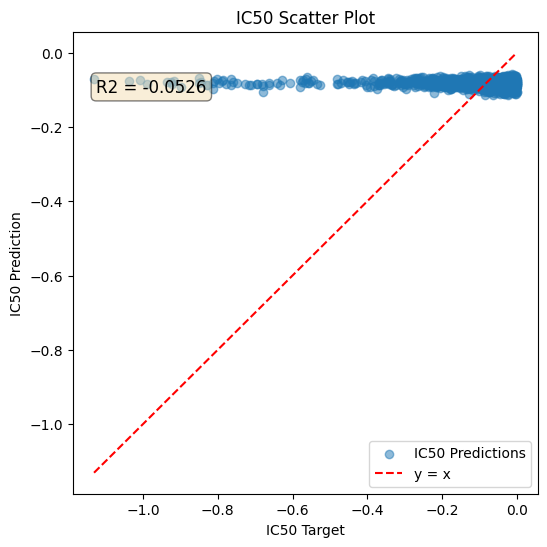

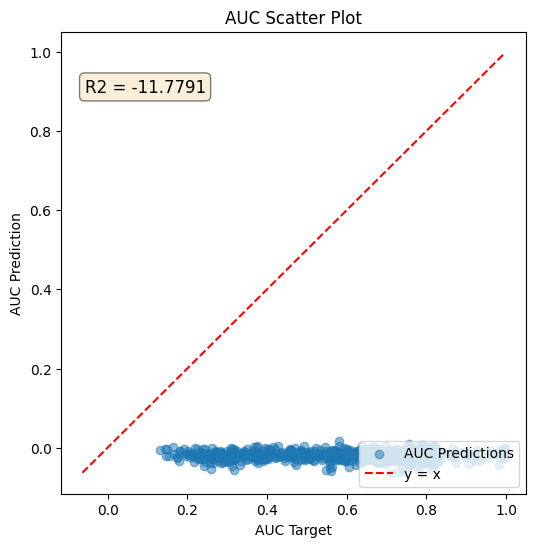

In [29]:
# utility function for testing
def test_model(model, test_loader, device):
    model.eval()
    ic50_preds, ic50_targets = [], []
    auc_preds, auc_targets = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            smiles_list, omics_data, targets = batch
            ic50_true, auc_true = targets[:, 0], targets[:, 1]

            smiles_list = smiles_list.to(device)
            omics_data = omics_data.to(device)
            ic50_true = ic50_true.to(device)
            auc_true = auc_true.to(device)

            ic50_pred, auc_pred = model(smiles_list, omics_data)

            ic50_mask = ~torch.isnan(ic50_true)
            auc_mask = ~torch.isnan(auc_true)

            if ic50_mask.sum() > 0:
                ic50_preds.append(ic50_pred[ic50_mask].cpu().numpy())
                ic50_targets.append(ic50_true[ic50_mask].cpu().numpy())
            if auc_mask.sum() > 0:
                auc_preds.append(auc_pred[auc_mask].cpu().numpy())
                auc_targets.append(auc_true[auc_mask].cpu().numpy())

        # list -> numpy
        ic50_preds = np.concatenate(ic50_preds) if ic50_preds else np.array([])
        ic50_targets = np.concatenate(ic50_targets) if ic50_targets else np.array([])
        auc_preds = np.concatenate(auc_preds) if auc_preds else np.array([])
        auc_targets = np.concatenate(auc_targets) if auc_targets else np.array([])

        # evaluation
        metrics = {}
        if len(ic50_preds) > 0:
            metrics["IC50_MSE"] = mean_squared_error(ic50_targets, ic50_preds)
            metrics["IC50_MAE"] = mean_absolute_error(ic50_targets, ic50_preds)
            metrics["IC50_R2"] = r2_score(ic50_targets, ic50_preds)
        if len(auc_preds) > 0:
            metrics["AUC_MSE"] = mean_squared_error(auc_targets, auc_preds)
            metrics["AUC_MAE"] = mean_absolute_error(auc_targets, auc_preds)
            metrics["AUC_R2"] = r2_score(auc_targets, auc_preds)

        print("\n **Test Results:**")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")
        
        # IC50 Scatter Plot
        if len(ic50_preds) > 0:
            plt.figure(figsize=(6,6))
            plt.scatter(ic50_targets, ic50_preds, alpha=0.5, label="IC50 Predictions")
            # y = x 
            min_val = min(np.min(ic50_targets), np.min(ic50_preds))
            max_val = max(np.max(ic50_targets), np.max(ic50_preds))
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
            plt.xlabel("IC50 Target")
            plt.ylabel("IC50 Prediction")
            plt.title("IC50 Scatter Plot")
            # R2
            plt.text(0.05, 0.90, f"R2 = {metrics['IC50_R2']:.4f}", transform=plt.gca().transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
            plt.legend(loc="lower right")
            plt.show()
        
        # AUC Scatter Plot
        if len(auc_preds) > 0:
            plt.figure(figsize=(6,6))
            plt.scatter(auc_targets, auc_preds, alpha=0.5, label="AUC Predictions")
            min_val = min(np.min(auc_targets), np.min(auc_preds))
            max_val = max(np.max(auc_targets), np.max(auc_preds))
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
            plt.xlabel("AUC Target")
            plt.ylabel("AUC Prediction")
            plt.title("AUC Scatter Plot")
            plt.text(0.05, 0.90, f"R2 = {metrics['AUC_R2']:.4f}", transform=plt.gca().transAxes, 
                     fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
            plt.legend(loc="lower right")
            plt.show()
        
        return metrics

# load the best model
model.load_state_dict(torch.load(best_model_filename, map_location=device))

# test
test_metrics = test_model(model, test_loader, device)
